# Study 1 part 1: Sketching sounds - an exploratory study on sound-shape associations

In [5]:
#Libraries that are used in this notebook
#Plotting
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, BoundaryNorm, ListedColormap
from matplotlib.colors import ListedColormap, LogNorm
from matplotlib.gridspec import GridSpec

#Datastructures
import pandas as pd
import numpy as np
import json
import math

#Sound feature extraction
import librosa
import librosa.display
import timbral_models
import soundfile as sf

#Statistics and data processing
import scipy.stats as stats
from statsmodels.sandbox.stats.runs import cochrans_q
import scipy.signal as signal
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import normalize,minmax_scale
from sklearn.mixture import GaussianMixture
import pingouin as pg

#"Homemade" scripts
from sketchinfo import eucledian_dist
from shortstraw import *
from sketchinfo import *
from prepare_drawing_data import *

#Image processing
import PIL as img

#Misc
from collections import Counter
from wordcloud import WordCloud, get_single_color_func

In [6]:
#Colour map to display p-values < 0.05 red in a dataframe

def color_negative_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for negative
    strings, black otherwise.
    """
    
    color = 'red' if val < 0.05 else 'black'
    return 'color: %s' % color

# Import Datasets 

JSON file contains all data collected from the study

CSV file for particpant information has been extracted from the firebase JSON file with a different python script.

CSV file for categorising the sketches has been created manually based on the actual sketches and the participant interviews: 

In [7]:
#Create array to name sounds 
sound_index = ['Crackles','Telephonic','Strings','String Grains','Subbass','Noise','Piano','Impact','Processed Guitar','Electric Guitar']

#Define important constants  
nos = 10 #Number of Sounds
nop = 28 #Number of Participants

#Import JSON file
with open('../../Data/Datasets/data.json','r') as f:
    raw_data = json.load(f)
    
#Create dataframe with personal information from CSV
personal_df = pd.read_csv (r'../../Data/Datasets/personal_data.csv') 

#Create dataframe with sketch categories that were obtained from K-Means clustering
#0: 1: 2: 3: 4:
cat_df = pd.read_csv(r'../../Data/Datasets/sketches_assigned_to_clusters.csv',index_col=0)
#Sketch pt24snd10B is empty because of a mistake by the participant, copy cluster assignment from pt24snd10
cat_df['Pt24B']['Electric Guitar'] = cat_df['Pt24']['Electric Guitar']

#Create dataframe with data extracted from interviews
interview_df = pd.read_csv(r'../../Data/Datasets/interviews_quantitative.csv')

#Create dataframe with the raw sketch data from the p5.js canvas for each participant and sound
sketch_data,order_data = prepare_drawing_data(raw_data,nos)

# I. General Information 

## 1. Participant Dataframe 

In [8]:
#personal_df #uncomment to display frame

## 2. Display participant summary as barplots

<AxesSubplot:title={'center':'Participants by Music Proficiency'}>

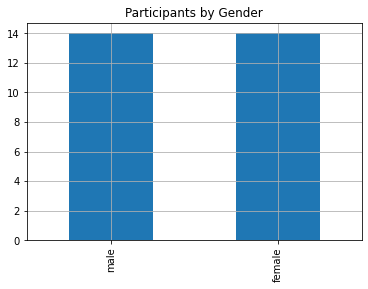

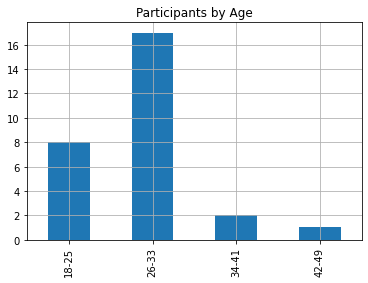

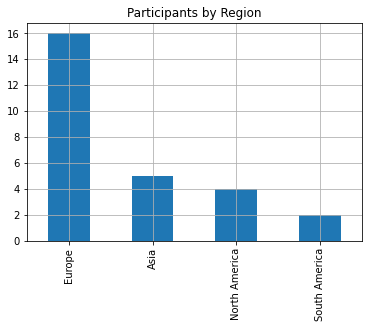

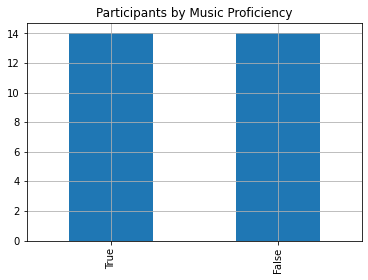

In [9]:
#Gender
series = personal_df['Gender'].value_counts()
gender_df = series.to_frame()
gender_df.plot.bar(title='Participants by Gender',legend=False,grid=True)

#Age
series = personal_df['Age'].value_counts(sort=False)
age_df = series.to_frame()
age_df = age_df.sort_index()
age_df.plot.bar(title='Participants by Age',legend=False, grid=True)

#Continent
series = personal_df['Continent'].value_counts()
continent_df = series.to_frame()
continent_df.plot.bar(title='Participants by Region',legend=False, grid=True)

#Musician 
series = personal_df['Music Pro'].value_counts()
musician_df = series.to_frame()
musician_df.plot.bar(title='Participants by Music Proficiency',legend=False, grid=True)

# II. Interview analysis

## 1. Thematic analysis

Thematic analysis proposed by Braun and Clarke has been applied to the transcribed interviews.  

In [10]:
#Categories
music_jargon = ['DAW','MIR','amplitude','attack','waveform','vibrato','transient','timbre','synthesis','spectrum','spectrogram','resonant','reverb','panning','sustained','oscillating','onset','modulation','harmonics','granular','frequency','envelope','distortion','volume','tonal','tuning','source','binaural','electronic','groove','rhythmic','drone','dynamic','decay','pitch','processing','presence','accentuated','ambient','chord','monotone']
sound_source = ['wave','water','strings','sand','rain','piano','explosion','firework','guitar','gun','impact','instrument','laser','lightsabre','boat']
sound_adjective =['buzzy','grainy','scratchy','pure','fragmented','crackly','clear','clean','click','noise','loud']
visual = ['texture','symmetry','colour','circle','blob','boxy','bright','curve','edge','flat','gradient','jagged','line','pyramid','round','scribbly','shape','sharp','spikey','square','triangle']
temporal = ['time','vibrating','static','pulse','movement','impulse','abrupt','continuous']
spatial = ['spatial','size','short','high','front','deep','dense','sparse','low','long','space','hollow','big']
emotional = ['strong','shaking','scary','harsh','gentle','feeling','aggressive','comfortable','peaceful','ominious','soft','smooth','mellow','comical']
abstract_words = ['structure','stochastic','rigid','abstract','energy','intensity','spark']

sound_description = []
for i in range(interview_df.shape[0]):
    sound_description.extend(interview_df['Sound Description'].str.split()[i])

sound_description_categories = np.zeros(8)
for pt in range(interview_df.shape[0]):
    words = interview_df['Sound Description'].str.split()[pt]   
    for word in words:       
        if word in music_jargon:
            sound_description_categories[0] += 1
        elif word in sound_source:
            sound_description_categories[1] += 1
        elif word in sound_adjective:
            sound_description_categories[2] += 1
        elif word in visual:
            sound_description_categories[3] += 1
        elif word in temporal:
            sound_description_categories[4] += 1
        elif word in spatial:
            sound_description_categories[5] += 1
        elif word in emotional:
            sound_description_categories[6] += 1
        elif word in abstract_words:
            sound_description_categories[7] += 1

            
Counter(sound_description).most_common(10)

[('piano', 16),
 ('strings', 11),
 ('guitar', 10),
 ('noise', 8),
 ('crackly', 7),
 ('movement', 7),
 ('flat', 6),
 ('line', 6),
 ('amplitude', 6),
 ('spatial', 6)]

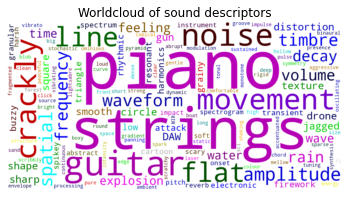

In [11]:
class GroupedColorFunc(object):
    """Create a color function object which assigns DIFFERENT SHADES of
       specified colors to certain words based on the color to words mapping.

       Uses wordcloud.get_single_color_func

       Parameters
       ----------
       color_to_words : dict(str -> list(str))
         A dictionary that maps a color to the list of words.

       default_color : str
         Color that will be assigned to a word that's not a member
         of any value from color_to_words.
    """

    def __init__(self, color_to_words, default_color):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()]

        self.default_color_func = get_single_color_func(default_color)

    def get_color_func(self, word):
        """Returns a single_color_func associated with the word"""
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

# Since the text is small collocations are turned off and text is lower-cased
text = ''
for word in sound_description:
    text += word + ' '
wc = WordCloud(collocations=False,width=1600,height=800,background_color='white').generate(text)

color_to_words = {}
color_to_words['blue'] = music_jargon
color_to_words['magenta'] = sound_source
color_to_words['red'] = sound_adjective
color_to_words['green'] = visual
color_to_words['indigo'] = temporal
color_to_words['cyan'] = spatial
color_to_words['orange'] = emotional
color_to_words['yellow'] = abstract_words

# Words that are not in any of the color_to_words values
# will be colored with a grey single color function
default_color = 'grey'

# Create a color function with single tone
# grouped_color_func = SimpleGroupedColorFunc(color_to_words, default_color)

# Create a color function with multiple tones
grouped_color_func = GroupedColorFunc(color_to_words, default_color)

# Apply our color function
wc.recolor(color_func=grouped_color_func)

#Save File
#wc.to_file('wordcloud.png')
# Plot
plt.figure()
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.title('Worldcloud of sound descriptors')
plt.show()

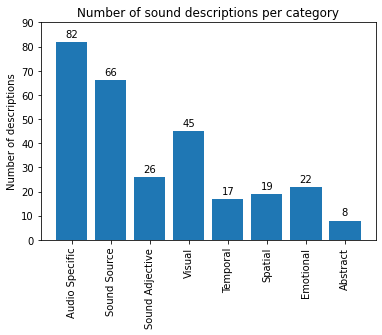

In [12]:
x = np.arange(sound_description_categories.shape[0])
width = 0.8
plt.bar(x,sound_description_categories, width)
plt.title('Number of sound descriptions per category')
plt.ylabel('Number of descriptions')
plt.ylim(0,90)
plt.xticks(x,['Audio Specific','Sound Source','Sound Adjective','Visual','Temporal','Spatial','Emotional','Abstract'])
#Display names on x-axis

for i,x_pos in enumerate(x):
    plt.text(x_pos,sound_description_categories[i]+2,s=str(int(sound_description_categories[i])),horizontalalignment='center')

_, labels = plt.xticks()
plt.setp(labels, rotation=90)   
    
plt.show()

## 2. Interface and Task rating 

From the interviews we extracted a value from 0-4 that says how participants rated the interaction with the interface and how difficult they thought the task was. 

In [13]:
#Analyse data on difficulty of task and the drawing interface
difficulty = interview_df['Difficulty']
interface = interview_df['Drawing Interface']

interface_description = []
for i in range(interview_df.shape[0]):
    words = interview_df['Preferred Interface'].str.split()[i]
    if isinstance(words,str):
        interface_description.append(words)
    elif isinstance(words,list):
        interface_description.extend(words)

print(Counter(interface_description).most_common(10))
print('Mean difficulty ' + '{:1.2f}'.format(np.mean(difficulty)))
print('Mean interface satisfaction ' + '{:1.2f}'.format(np.mean(interface)))
    

[('pen', 12), ('colour', 3), ('mouse', 2), ('brushstrokes', 2), ('tablet', 2), ('charcoal', 1), ('touchpad', 1), ('3D', 1), ('erase', 1), ('paint', 1)]
Mean difficulty 2.32
Mean interface satisfaction 1.32


# III. Audio Analysis

## 1. Feature extraction

Extracting features with the librosa library and the timbreModels library.


In [14]:
#Names of extracted audio features
#'Reverb' was dropped in later analysis 
#because it did not provide a distinguishing feature for the sounds 
audio_feature_names = ['Flatness Mean',
                       'Centroid Mean',
                       'RMS Mean',
                       'RMS Slope',
                       'Zero Crossing Mean',
                       'Hardness','Depth',
                       'Brightness',
                       'Roughness',
                       'Warmth',
                       'Sharpness',
                       'Boominess',
                       'Reverb']

In [15]:
#Find local maxima and minima
def local_extrema(array):
    maxima = []
    minima = []
    for i in range(1,len(array)-1):
        if array[i-1]<array[i] and array[i]>array[i+1]:
            maxima.append(i)
        if array[i-1]>array[i] and array[i]<array[i+1]:
            minima.append(i)
    return maxima,minima

#Calculate gradient between minima and maxima 
def extrema_gradient(maxima,minima,y):
    l = len(maxima)
    y = minmax_scale(y)
    min_index = 0
    gradients = []
    for max_index in range(l-1):
        i = maxima[max_index]
        i_next = maxima[max_index+1]
        j = minima[min_index]
        while j<i:
            min_index += 1
            j = minima[min_index]
        if i<j and j<i_next:
            m1 = (y[j]-y[i])/(j-i)
            m2 = (y[i_next]-y[j])/(i_next-j)
            gradients.append(m1)
            gradients.append(m2)
            min_index += 1
    
    return gradients

In [16]:
sr = 44100

spec_info = np.empty([10,13])
mfccs = []
flatness = []
centroid = []
rms = []
timbre = []
for i in range(nos):
    # Load the example clip
    filename = '../../Data/Audio/sound' + str(i+1) + '.wav'
    y, sr = librosa.load(filename,sr=sr)
    
    #Get rid of silence in audio
    y, index = librosa.effects.trim(y)
    
    #Save trimmed audiofiles
    #sf.write('sound' + str(i+1) + '_trimmed.wav',y,44100,'PCM_24')
    
    #Calculate flatness or Wiener Entropy
    f = librosa.feature.spectral_flatness(y=y)
    flatness.append(f)
    spec_info[i,0] = np.mean(f)
    
    #Calculate spectral centroid frequency
    c = librosa.feature.spectral_centroid(y=y,sr=sr)
    centroid.append(c)
    spec_info[i,1] = np.mean(c)
    
    #Calculate Root Mean Square
    r = librosa.feature.rms(y=y)
    rms.append(r)
    spec_info[i,2] = np.mean(r)
    
    #Calculate the intensity of the root mean square
    b, a = signal.butter(5,0.1)
    smooth = signal.filtfilt(b,a,r[0], padlen=10)
    smooth = smooth[:len(smooth)-50] #Cut off last 50 frames to avoid the fade out
    max_x,min_x = local_extrema(smooth)
    max_y,min_y = [smooth[k] for k in max_x],[smooth[k] for k in min_x]
    
    mg = extrema_gradient(max_x,min_x,smooth)
    abs_mg = [abs(k) for k in mg]
    
    spec_info[i,3] = np.mean(abs_mg)
    
    #Calculate zero crossings
    zero = librosa.feature.zero_crossing_rate(y)
    spec_info[i,4] = np.mean(zero)
    
    #Calculate Timbre Features Andy Pierce Audio Commons
    timbre.append(timbral_models.timbral_extractor(filename))
    for j,feature_name in enumerate(timbre[-1]):
        spec_info[i,j+5] = timbre[-1][feature_name]

    
    #Calculate mfccs
    mfcc = librosa.feature.mfcc(y,sr=sr,n_mfcc=16)
    #mfcc = mfcc[...,:400] #Give all arrays the same shape
    mfccs.append(mfcc)


Calculating hardness...
/Users/sebastian/opt/anaconda3/lib/python3.8/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
Calculating depth...
/Users/sebastian/opt/anaconda3/lib/python3.8/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
Calculating brightness...
/Users/sebastian/opt/anaconda3/lib/python3.8/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
Calculating roughness...
/Users/sebastian/opt/anaconda3/lib/python3.8/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped samples in output.
  warnings.warn("Possible clipped samples in output.")
Calculating warmth...
/Users/sebastian/opt/anaconda3/lib/python3.8/site-packages/pyloudnorm/normalize.py:62: UserWarning: Possible clipped s

In [17]:
from scipy import signal

all_envelope_data = []

for snd in range(nos):
    b, a = signal.butter(5,0.1)
    y = signal.filtfilt(b,a,rms[snd][0], padlen=10)
    y = y[:len(y)-50] #Cut off last 50 frames to avoid the fade out
    max_x,min_x = local_extrema(y)
    max_y,min_y = [y[i] for i in max_x],[y[i] for i in min_x]
    
    mg = extrema_gradient(max_x,min_x,y)
    abs_mg = [abs(i) for i in mg]
    
    all_envelope_data.append([len(max_x)+len(min_x),np.mean(abs_mg)]) 

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


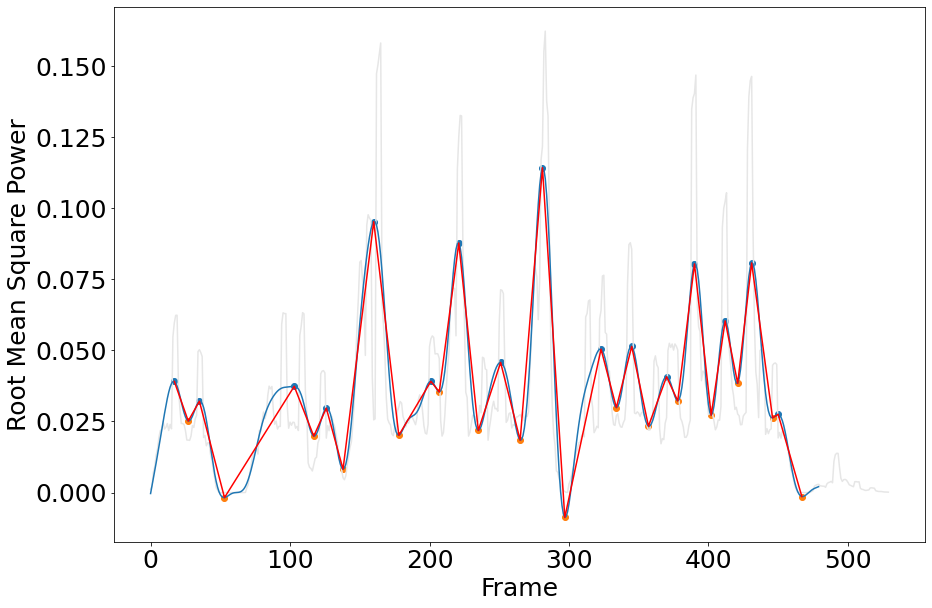

In [18]:
from scipy import signal

snd = 0

b, a = signal.butter(5,0.1)
y = signal.filtfilt(b,a,rms[snd][0], padlen=10)
y = y[:len(y)-50] #Cut off last 50 frames to avoid the fade out
max_x,min_x = local_extrema(y)
max_y,min_y = [y[i] for i in max_x],[y[i] for i in min_x]

all_extrema_x = []
all_extrema_y = []
for i in range(len(max_x)):
    all_extrema_x.append(max_x[i])
    all_extrema_x.append(min_x[i])
    all_extrema_y.append(max_y[i])
    all_extrema_y.append(min_y[i])
    
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 25}

plt.rc('font', **font)
plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=25)

f = plt.figure() 
f.set_figwidth(13.5) 
f.set_figheight(9)
    
plt.plot(rms[snd][0],color=(0.9,0.9,0.9))
plt.scatter(max_x,max_y)
plt.scatter(min_x,min_y)
plt.plot(y)
plt.ylabel('Root Mean Square Power')
plt.xlabel('Frame')
# plt.title('RMS Slope')
plt.tight_layout()
plt.plot(all_extrema_x,all_extrema_y,color='red')
plt.savefig('RMS_Slope.png')
plt.show()

In [19]:
audio_feature_names

['Flatness Mean',
 'Centroid Mean',
 'RMS Mean',
 'RMS Slope',
 'Zero Crossing Mean',
 'Hardness',
 'Depth',
 'Brightness',
 'Roughness',
 'Warmth',
 'Sharpness',
 'Boominess',
 'Reverb']

In [20]:
def format_tex(float_number):
    exponent = np.floor(np.log10(float_number))
    mantissa = float_number/10**exponent
    mantissa_format = str(mantissa)[0:3]
    return "${0} * 10^{1}$".format(mantissa_format, str(int(exponent)))


#Display audio analysis dataframe
audio_df = pd.DataFrame(data = spec_info,index=sound_index,columns=audio_feature_names)
lta_df = audio_df.drop('Reverb',axis=1)

round_dict = {}
type_dict = {}
for j, name in enumerate(audio_feature_names[1:12]):
    i = j+1
    if i == 0:
        r = 1
        t = float
    elif i == 1:
        r = 0
        t = int
    elif i == 3:
        r = 0
        t = int
    elif i<5:
        r = 3
        t = float
    else:
        r = 0
        t = int
        
    round_dict.update({name: r})
    type_dict.update({name: t})


lta_df['RMS Slope']*=1000

rdf = lta_df.round(round_dict)
rdf = rdf.astype(type_dict)


for i,val in enumerate(rdf['Flatness Mean']):
    rdf.iloc[i,0] = format_tex(val)
    

# print(rdf.to_latex())
lta_df.to_csv('audiofeatures-study1.csv')

## 2. Dissimilarity Matrix

- First: Train GMMs on the MFCCs values and calculate symmetrised KL-Divergence for dissimiliarty matrix

In [21]:
#Use mfccs
sound_models = []
for snd in range(nos):
    feature = mfccs[snd].T
    #feature_norm = minmax_scale(feature).T
    g = GaussianMixture(n_components=10,covariance_type='full',n_init=10,max_iter=500)
    g.fit(feature)
    sound_models.append(g)

In [22]:
from sklearn.mixture import GaussianMixture

def gmm_js(gmm_p, gmm_q, n_samples=1000):
    X,y = gmm_p.sample(n_samples)
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y,y = gmm_q.sample(n_samples)
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return 0.5 * (log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2)))

def gmm_kl(gmm_p, gmm_q, n_samples=10**5):
    X,y = gmm_p.sample(n_samples)
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    
    Y,y = gmm_q.sample(n_samples)
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    
    
    return 0.5*(abs(log_p_X.mean() - log_q_X.mean()) + abs(log_p_Y.mean() - log_q_Y.mean()))

In [23]:
dm = np.zeros((nos,nos))

for i in range(nos):
    #Don't calculate the symmetric values twice, save computing time
    for j in range(i,nos):
        d = gmm_kl(sound_models[i],sound_models[j])
        dm[i,j]= d
        dm[j,i]= d        

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


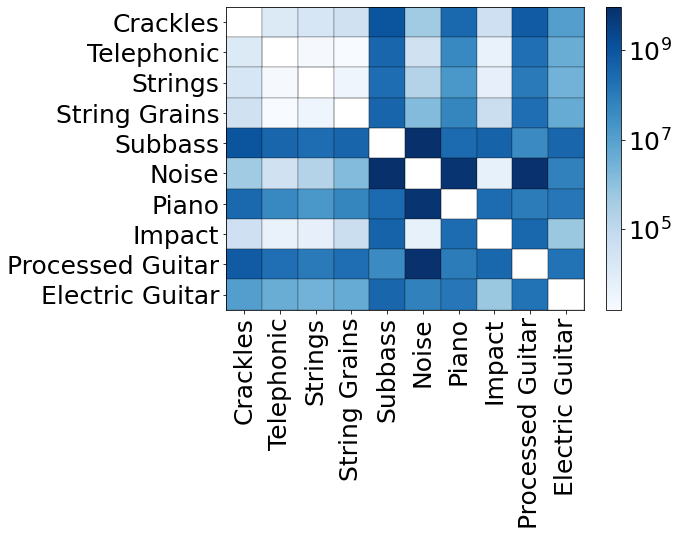

In [24]:
fig, ax = plt.subplots(figsize=(10,8))
dis_matrix = ax.pcolor(dm, cmap=plt.cm.__dict__['Blues'], edgecolors='k', alpha=1, snap=True, norm=LogNorm())

#legend
cbar = plt.colorbar(dis_matrix)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(dm.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(dm.shape[0]) + 0.5, minor=False)
ax.invert_yaxis()

#labels
column_labels = sound_index
row_labels = sound_index
ax.set_xticklabels(column_labels, minor=False, rotation=90)
ax.set_yticklabels(row_labels, minor=False)

fig.tight_layout()
plt.show()

- Now: Create dissimilarity matrix based on eucledian distance between audio feature vectors 

In [25]:
#Eucledian distance between standardised feature vectors
std_audio_ft = np.empty([10,12])

for i in range(spec_info.shape[1]-1):
    temp_column = minmax_scale(spec_info[:,i],(0,1))
    for j,val in enumerate(temp_column):
        std_audio_ft[j,i] = val

eucl_dst = np.zeros((nos,nos))
for i in range(nos):
    #Don't calculate the symmetric values twice, save computing time
    a = std_audio_ft[i]
    for j in range(i,nos):
        b = std_audio_ft[j]
        d = np.linalg.norm(b-a)
        eucl_dst[i,j]= d
        eucl_dst[j,i]= d


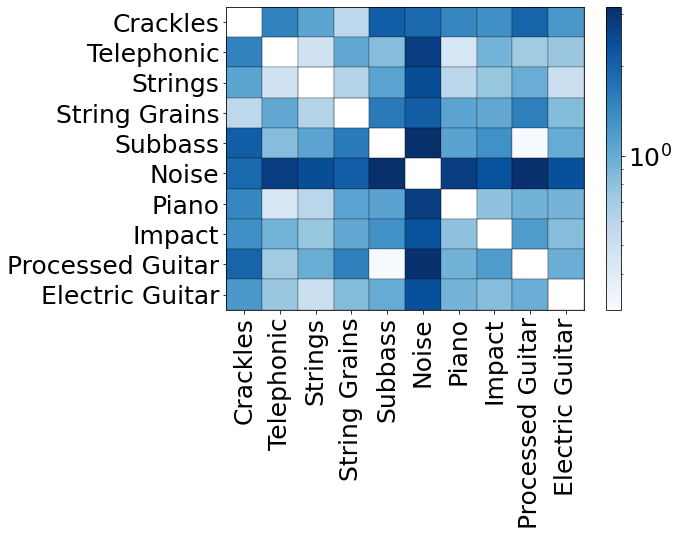

In [26]:
fig, ax = plt.subplots(figsize=(10,8))
dis_matrix = ax.pcolor(eucl_dst, cmap=plt.cm.__dict__['Blues'], edgecolors='k', alpha=1, snap=True, norm=LogNorm())

#legend
cbar = plt.colorbar(dis_matrix)

# put the major ticks at the middle of each cell
ax.set_xticks(np.arange(dm.shape[1]) + 0.5, minor=False)
ax.set_yticks(np.arange(dm.shape[0]) + 0.5, minor=False)
ax.invert_yaxis()

#labels
column_labels = sound_index
row_labels = sound_index
ax.set_xticklabels(column_labels, minor=False, rotation=90)
ax.set_yticklabels(row_labels, minor=False)

fig.tight_layout()
plt.show()

- Retrieve the 3rd,6th and 9th most dissimlar sound for a reference sound. This data can be used for the analysis of Study 1 part 2: Seeing Sounds, Hearing Shapes

In [27]:
snd = 9
ranks = np.argsort(eucl_dst[snd])

print('For '+sound_index[snd]+':\n3.'+sound_index[ranks[3]] +'\n6.'+sound_index[ranks[6]]+'\n9.'+sound_index[ranks[9]])

For Electric Guitar:
3.Impact
6.Processed Guitar
9.Noise


# IV. Sketch Analysis

## 1. Different sketch categories

Categories obtained from K-Means clustering on Card Sorting Results are:
- **Cluster 1: Grains**
    - Repeated distinct abstract elements
    - Keywords: Small, repeated, grainy, spots, multiple components, layers, abstract, distinct

- **Cluster 2: Lines**
    - Small number of long lines following various shapes
    - Keywords: round,soft,continuous, jagged, irregular, continuous, simple, single, lines
    
- **Cluster 3: Objects/Scenes**
    - Depictions of real-life scenarios with occasional abstract influences
    - Keywords: real-life objects, environment, actions or feelings, abstract structures

- **Cluster 4: Chaotic/Jagged**
    - Chaotic, jagged sketches; single or multiple elements
    - Keywords: chaotic, intense, jagged, multiple layers, single objects
    
- **Cluster 5: Radiating**
    - Sketches that evolve from a common, central origin
    - Keywords: round, circular, spiral, sharp, shaking, distinct objects, radiating, natural shapes
    


In [70]:
cat_names = {0: 'Grains', 1: 'Lines', 2: 'Objects\nScenes', 3: 'Chaotic\nJagged', 4: 'Radiating'}

number_of_clusters = len(cat_names)

#Use standard colour palett
prop_cycle = plt.rcParams['axes.prop_cycle']
colour = prop_cycle.by_key()['color']

<ipython-input-82-5f34dd1a1ac3>:57: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(xlabels) #Display names on x-axis
<ipython-input-82-5f34dd1a1ac3>:108: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(labels,rotation=45,ha='right')


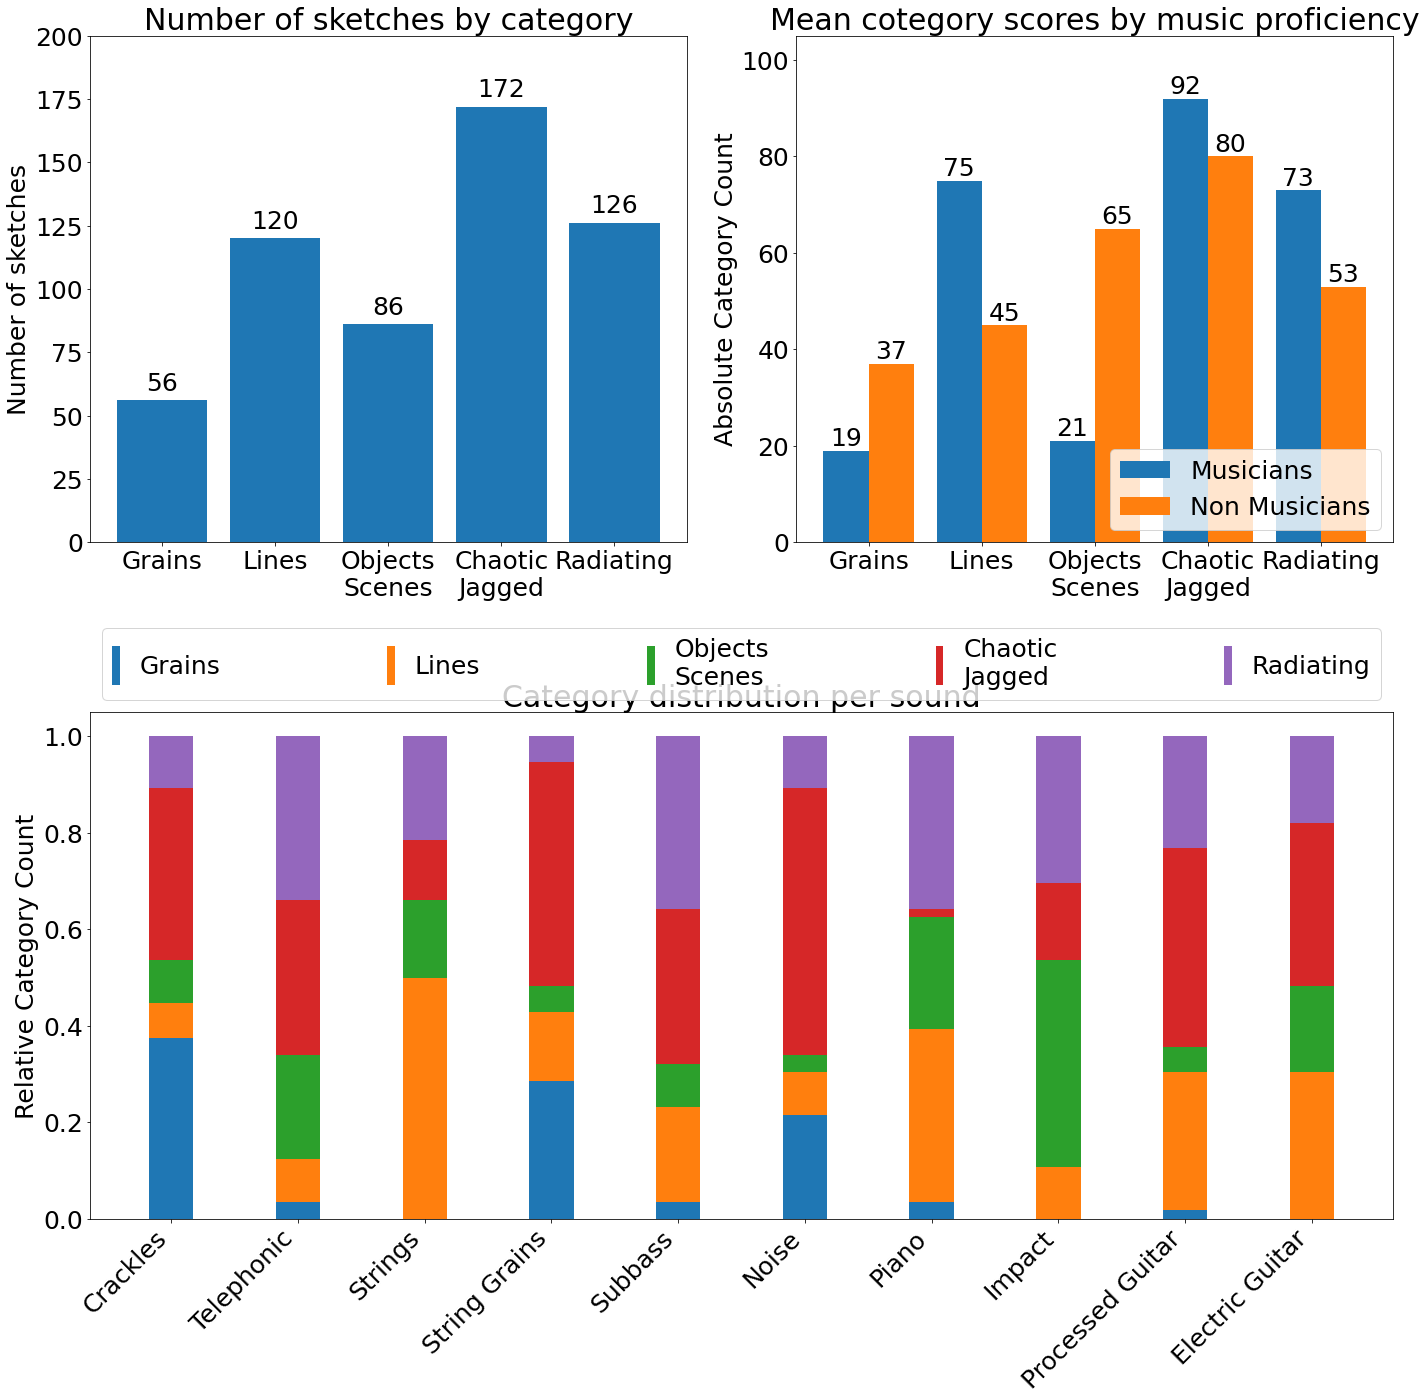

In [82]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 25}

plt.rc('font', **font)

#Count how many sketches are in each category overall
cat_counts = np.zeros(number_of_clusters,dtype=int)
for pt in cat_df.columns:
    column_counts = cat_df[pt].value_counts()
    keys = column_counts.keys()
    for key in keys:
        cat_counts[key] += column_counts[key]
        
#Count how many sketches are in each category divided by musicians and non-musicians
musician_df = personal_df.query('`Music Pro` == True')
musician_indices = list(musician_df.index)

m_cat_counts = np.zeros(number_of_clusters,dtype=int)
nm_cat_counts = np.zeros(number_of_clusters,dtype=int)

for i,pt in enumerate(cat_df.columns):
    column_counts = cat_df[pt].value_counts()
    keys = column_counts.keys()
    for key in keys:
        if math.floor(i/2) in musician_indices:
            m_cat_counts[key] += column_counts[key]
        else:
            nm_cat_counts[key] += column_counts[key]
            
#Count how categories are distributed for each sound
snd_cat_counts = np.zeros((number_of_clusters,nos))
    
for i in range(2*nop):
    for j in range(nos):
        cat = cat_df.iloc[j,i]
        snd_cat_counts[cat,j] += 1


#Plot graphs        
fig = plt.figure(figsize=(20,20))
gs = GridSpec(2,2)

ax1 = fig.add_subplot(gs[0,0])
ax2 = fig.add_subplot(gs[0,1])
ax3 = fig.add_subplot(gs[1,:])

#Sketches per category
x = np.arange(number_of_clusters)
width = 0.8
ax1.bar(x,cat_counts, width)
ax1.set_title('Number of sketches by category')
ax1.set_ylabel('Number of sketches')
ax1.set_ylim(0,200)
xlabels = [cat_names[i] for i in range(number_of_clusters)]
xlabels.insert(0,'')
ax1.set_xticklabels(xlabels) #Display names on x-axis

for i,x_pos in enumerate(x):
    ax1.text(x_pos,cat_counts[i]+4,s=str(cat_counts[i]),horizontalalignment='center')
  
#Sketches per category by musicians and non-musicians
#Grouped Bar Plot
labels = [cat_names[i] for i in range(number_of_clusters)]            
x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

rects1 = ax2.bar(x - width/2, m_cat_counts, width, label='Musicians')
rects2 = ax2.bar(x + width/2, nm_cat_counts, width, label='Non Musicians')

# Add some text for labels, title and custom x-axis tick labels, etc.
ax2.set_title('Mean cotegory scores by music proficiency')
ax2.set_ylabel('Absolute Category Count')
ax2.set_ylim(0,105)
ax2.set_xticks(x)
ax2.set_xticklabels(labels)
ax2.legend(loc="lower right")

def autolabel(rects,ax):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(str(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 0),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1,ax2)
autolabel(rects2,ax2)

#Sketch distribution for sounds
labels = sound_index
width = 0.35       # the width of the bars: can also be len(x) sequence
bt = np.zeros(nos) # y positions of stacked bars
for cat in range(number_of_clusters):
    h = snd_cat_counts[cat,:]/(2*nop)
    ax3.bar(labels, h, width, bottom=bt, label=cat_names[cat], color=colour[cat])
    bt += h 
ax3.set_ylabel('Relative Category Count')
ax3.legend(bbox_to_anchor=(0, 1, 1, 0), loc="lower left", mode="expand", ncol=5,handlelength=0.3,handleheight=2)

for tick in ax3.get_xticklabels():
    #tick.set_rotation(90) uncomment for rotation
    pass
ax3.set_title('Category distribution per sound')

ax3.set_xticklabels(labels,rotation=45,ha='right')



plt.tight_layout()
# plt.savefig('Categories_Sound.png')
# plt.savefig('Categories_Music_Pro.png')
plt.show()

Test for significant differences in category choice between musicians and non-musicians

In [30]:
#Check for significant differences between musicians and non-musicians

obs = np.array([m_cat_counts,nm_cat_counts])
chi2,p,dof,ex = stats.chi2_contingency(obs)

print('''Differences in category numbers between musicians and non-musicians
Nullhypothesis: Both groups show the same numbers for each category\n''')
for i in range(number_of_clusters): 
    s, p = stats.chisquare([m_cat_counts[i],nm_cat_counts[i]],ex[:,i])
    
    print(cat_names[i] + ': Statistics: ' + '{0:.2f}'.format(s) + ' P-Value: ' + '{0:.7f}'.format(p))
    if p<0.05:
        print('The Nullhypothesis can be rejected')
    else:
        print('The Nullhypothesis cannot be rejected')
    print('')


Differences in category numbers between musicians and non-musicians
Nullhypothesis: Both groups show the same numbers for each category

Grains: Statistics: 5.79 P-Value: 0.0161569
The Nullhypothesis can be rejected

Lines: Statistics: 7.50 P-Value: 0.0061699
The Nullhypothesis can be rejected

Objects
Scenes: Statistics: 22.51 P-Value: 0.0000021
The Nullhypothesis can be rejected

Chaotic
Jagged: Statistics: 0.84 P-Value: 0.3601961
The Nullhypothesis cannot be rejected

Radiating: Statistics: 3.17 P-Value: 0.0747914
The Nullhypothesis cannot be rejected



Test for significant differences in the choice for the Object/Scenes category between the sounds. 

In [31]:
#Cochran Q to test for differences between sounds
#binary response, either category 3 or not category 3
cat3_boolean = np.array(cat_df.T.to_numpy() == 2)

#Null Hypothesis: Sound has no effect on the distribution of category 3

# First apply cochran to all measurments
s,p = cochrans_q(cat3_boolean)

print('Cochran Q test for all sounds:\nStatistics: ' + '{0:.2f}'.format(s) + ' P-Value: ' + '{0:.11f}'.format(p))

# Post-hoc pairwaise analysis with cochran
cochran_p_values = np.zeros([nos,nos])
ntests = 45
for i in range(nos):
    for j in range(i+1,nos):
        s,p = cochrans_q(np.array([cat3_boolean[:,i],cat3_boolean[:,j]]).swapaxes(0,1))
        cochran_p_values[i,j] = cochran_p_values[j,i] = p #* ntests #Bonferroni 

d = pd.DataFrame(data=cochran_p_values, index=sound_index, columns=sound_index).style.applymap(color_negative_red)

print('\nResults from post-hoc pairwise analysis:')
print('P-Values from Cochran Q test between sounds.' + 
      'p<0.05 indicates that there is a significant difference in the prevelance of Category 3: Objects/Scenes')

d

Cochran Q test for all sounds:
Statistics: 67.07 P-Value: 0.00000000006

Results from post-hoc pairwise analysis:
P-Values from Cochran Q test between sounds.p<0.05 indicates that there is a significant difference in the prevelance of Category 3: Objects/Scenes


,Crackles,Telephonic,Strings,String Grains,Subbass,Noise,Piano,Impact,Processed Guitar,Electric Guitar
Crackles,0.000000,0.008151,0.157299,0.317311,1.000000,0.256839,0.011412,0.000034,0.317311,0.131668
Telephonic,0.008151,0.000000,0.438578,0.002700,0.019631,0.003892,0.781511,0.004678,0.006656,0.617075
Strings,0.157299,0.438578,0.000000,0.083265,0.157299,0.019631,0.285049,0.000275,0.057780,0.763025
String Grains,0.317311,0.002700,0.083265,0.000000,0.479500,0.654721,0.003892,0.000005,1.000000,0.052204
Subbass,1.000000,0.019631,0.157299,0.479500,0.000000,0.256839,0.032509,0.000074,0.479500,0.131668
Noise,0.256839,0.003892,0.019631,0.654721,0.256839,0.000000,0.002282,0.000003,0.654721,0.020921
Piano,0.011412,0.781511,0.285049,0.003892,0.032509,0.002282,0.000000,0.016377,0.003892,0.405381
Impact,0.000034,0.004678,0.000275,0.000005,0.000074,0.000003,0.016377,0.000000,0.000005,0.004267
Processed Guitar,0.317311,0.006656,0.057780,1.000000,0.479500,0.654721,0.003892,0.000005,0.000000,0.052204
Electric Guitar,0.131668,0.617075,0.763025,0.052204,0.131668,0.020921,0.405381,0.004267,0.052204,0.000000


## 2. Feature extraction

Extract features from the sketch data through:
- Analysing the shape,size and content of the collected data to receive
    - Number of strokes, average stroke length, average stroke time, average speed
- Calculate the number of stroke intersections by adapting Bresenham's line algorithm
    - Intersections 
- Calculate feature points with the Shortstraw algorithm
    - Narrow Curves, Wide Curves, Obtuse Angles, Right Angles, Acute Angles


In [32]:
#Names of the extracted features
sketch_feature_names = ['Number of Strokes',
                        'Average Length [px]',
                        'Average Time [ms]',
                        'Average Speed [px/ms]',
                        'Intersections [1/100px]',
                        'Narrow Curves [1/100px]',
                        'Wide Curves [1/100px]',
                        'Obtuse Angles [1/100px]',
                        'Right Angles [1/100px]',
                        'Acute Angles [1/100px]']

In [33]:
# "Master Array" that holds all info and will be converted into pandas dataframe
sketch_info = []

#Master Arrays for feature info and raw data
all_feature_info = []
all_raw_angles = []
all_raw_curves = []

all_features = [] #Save all the features for GMM and disimilarity matrix 

all_ft_np = np.zeros((nos,2*nop,12))

#Iterate through all sounds
points = []
for sound_number in range(nos):
    #Sketch info arrays for each sound
    number_of_paths = []
    path_length = []
    path_time = []
    total_speed = []
    intersections = []
    
    #Feature info arrays for each sound
    st = [] #Straight lines
    cun = [] #Narrow curves
    cuw = [] #Wide curves
    ob = [] #Obtruse angles 
    ri = [] #Right angles
    ac = [] #Acute angles
    raw_angles = []
    raw_curves = []
    
    #Temp array to store all feature vectors for this sound
    af_temp = []
        
    #iterate through all participants
    for participant_number in range(nop):
        #Get both iterations of every sound for each participant
        for version in range(2):
            #Get info for sketch and add it array
            snd = str(sound_number+1)
            #Sketch pt24snd10B is empty because of a mistake of the participant, use sound pt24snd10 instead
            if version == 1 and not (participant_number==23 and sound_number==9): 
                snd += 'B'
            #Get dataset for this sound and participant
            sketch_paths = get_sketch_paths(participant=participant_number+1,sound=snd,sketch_data = sketch_data)    

            temp = get_sketchinfo(paths=sketch_paths)
            number_of_paths.append(temp[0])
            path_length.extend(temp[1])
            path_time.extend(temp[2])
            points.extend(temp[3])
            s = sum(temp[1])/sum(temp[2]) #Calculate overall speed dividing total length by total drawing time
            total_speed.append(s)

            #Get overlaps
            _,i = get_intersections(sketch_paths,canvas=(750,750))

            #Intersections per 100px path length
            this_i = 100*i/sum(temp[1])
            intersections.append(this_i)

            #Get feature points
            ss = short_straw(sketch_paths)
            #Get info about feature points
            feature_info = ss[2]
            raw_angles.extend(ss[4])
            raw_curves.extend(ss[5])
            #Divide by number of paths
            #st.append(feature_info['straight'])

            #Divide by total path length
            this_cun = 100*feature_info['narrow curve']/sum(temp[1])
            this_cuw = 100*feature_info['wide curve']/sum(temp[1])
            this_ob = 100*feature_info['obtuse']/sum(temp[1])
            this_ri = 100*feature_info['right']/sum(temp[1])
            this_ac = 100*feature_info['acute']/sum(temp[1])
            cun.append(this_cun)
            cuw.append(this_cuw)
            ob.append(this_ob)
            ri.append(this_ri)
            ac.append(this_ac)

            #Save data to master array for GMM
            '''
            #0:NumberOfPaths 1:Mean Path Length 2:Mean Time 3:Total Speed 4:Intersections
            5:Narrow Curve 6:Wide Curve 7:Obtuse 8:Right 9:Acute
            '''
            af_temp.append([temp[0],np.mean(temp[1]),np.mean(temp[2]),s,this_i,this_cun,this_cuw,
            this_ob,this_ri,this_ac, np.mean(ss[4]),np.mean(ss[5])])

            for k,ft in enumerate([temp[0],np.mean(temp[1]),np.mean(temp[2]),s,this_i,this_cun,this_cuw, this_ob,this_ri,this_ac, np.mean(ss[4]),np.mean(ss[5])]):
                all_ft_np[sound_number,participant_number*2 + version,k] = ft
                    

    #Get mean for each sketch info
    avg_number_of_paths = np.mean(number_of_paths)
    avg_path_length = np.mean(path_length)
    avg_path_time = np.mean(path_time)
    avg_speed = np.mean(total_speed)    
    avg_inter = np.mean(intersections)

    #Get means for each feature percentages
    #mean_st = np.mean(st)
    mean_cun = np.mean(cun)
    mean_cuw = np.mean(cuw)
    mean_ob = np.mean(ob)
    mean_ri = np.mean(ri)
    mean_ac = np.mean(ac)
    
    #Add feature info and raw data to arrays
    all_feature_info.append([mean_cun,mean_cuw,mean_ob,mean_ri,mean_ac,np.median(raw_angles),np.median(raw_curves)])
    all_raw_angles.append(raw_angles)
    all_raw_curves.append(raw_curves)
    #Add info to for this sound to "Master Array"
    sketch_info.append([avg_number_of_paths,avg_path_length,avg_path_time,1000*avg_speed,avg_inter])
    
    #Add to GMM array
    all_features.append(af_temp)


/Users/sebastian/opt/anaconda3/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/sebastian/opt/anaconda3/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Example of Intersections 

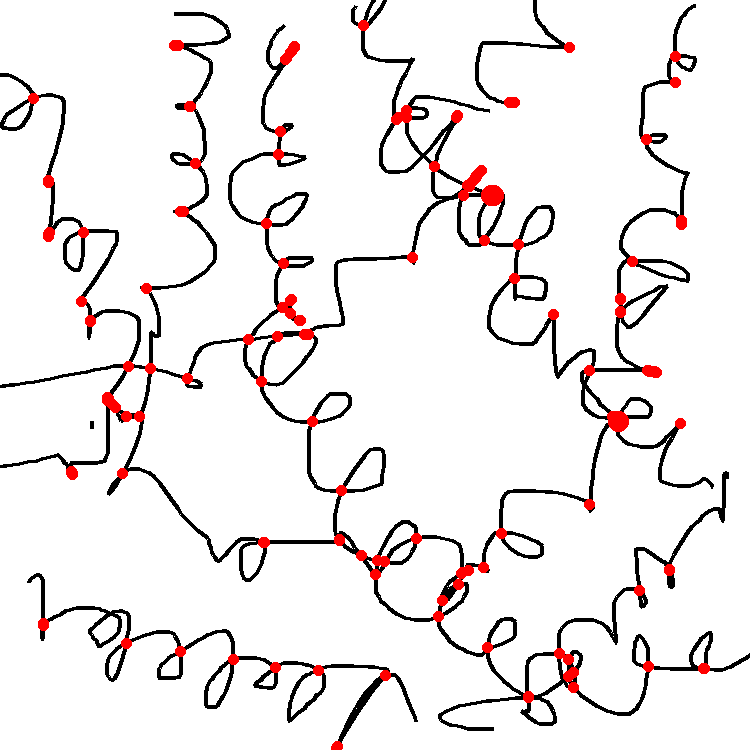

In [34]:
#Show example of intersections

d = get_sketch_paths(participant=10,sound='6B',sketch_data = sketch_data)

inter,i = get_intersections(d,canvas=(750,750))

s = draw_sketch(d,(0,0,0),bg=(255,255,255),strength=4)

draw = ImageDraw.Draw(s)

points = np.where(inter > 0)
for (x,y) in zip(points[1],points[0]):
    noi = int(inter[y,x])
    draw.ellipse((x-5*noi,y-5*noi,x+5*noi,y+5*noi),fill=(255,0,0))
    
s.save('intersections.png','png')

s

# image = img.Image.fromarray(im_array)
# image.show()

Display feature values

In [55]:
#Dataframe with features from all participants 
aft_df = pd.DataFrame(data = [np.nanmean(all_ft_np[i,:,:10],axis=0) for i in range(nos)],index=sound_index,columns=sketch_feature_names) 
aft_df  

,Number of Strokes,Average Length [px],Average Time [ms],Average Speed [px/ms],Intersections [1/100px],Narrow Curves [1/100px],Wide Curves [1/100px],Obtuse Angles [1/100px],Right Angles [1/100px],Acute Angles [1/100px]
Crackles,10.464286,470.501350,2795.669202,0.222895,1.776612,0.550596,0.603931,0.936347,0.219484,0.669470
Telephonic,5.964286,1090.878523,4613.099854,0.270581,1.046393,0.158782,0.373529,0.551332,0.078824,0.264508
Strings,3.875000,900.302798,4379.282104,0.263554,0.309629,0.096478,0.231431,0.280956,0.063697,0.090573
String Grains,10.107143,914.165287,3339.781745,0.282801,1.477265,0.243356,0.207913,0.576318,0.147259,0.541270
Subbass,4.482143,1328.417209,6153.713098,0.231558,0.919662,0.170728,0.426237,0.510736,0.076248,0.297364
Noise,12.767857,1816.444028,3540.277674,0.573719,2.366164,0.318269,0.215258,0.608472,0.160989,0.564977
Piano,3.785714,586.162106,3019.999659,0.287913,0.611298,0.061048,0.306617,0.195208,0.023794,0.057498
Impact,7.160714,1239.332344,3313.172799,0.514040,1.121272,0.143799,0.284280,0.235861,0.052700,0.314174
Processed Guitar,4.285714,1124.254510,4707.118583,0.333846,0.425585,0.173458,0.227775,0.490001,0.093024,0.215916
Electric Guitar,5.339286,1120.880002,4560.644153,0.333773,0.927074,0.118459,0.121684,0.345940,0.078824,0.395161


Test inter-rater reliability with Intraclass Correlation Coefficient ICC2k

In [52]:
ICC2k_df = None
test = [1 for _ in range(28)]
for ft in range(10):
    sounds = []
    participant = []
    scores = []

    for snd in range(nos):
        for i in range(2):
            d = all_ft_np[snd,i::2,ft].copy()

            #Box Cox can't handle zeros, therefore add 0.5*the next smalles values to any zero entries
            if np.min(d) == 0:
                smallest = np.min(d[np.nonzero(d)])*0.5
                d[d == 0] = smallest
                d = d[np.nonzero(d)]

            d_fitted = stats.boxcox(d,lmbda=0)
            
            sounds.extend([2*snd+i for _ in range(nop)])

            participant.extend([j for j in range(nop)])
            scores.extend(d_fitted)

    l = [sounds,participant,scores]
    icc_pd = pd.DataFrame(data=np.array(l).transpose(),columns=("Sounds","Participant","Scores"))   
    # np.array([sounds,participant,scores])
    icc = pg.intraclass_corr(data=icc_pd,targets='Sounds',raters="Participant",ratings="Scores").round(3)
    if ICC2k_df is None:
        ICC2k_df = icc[icc.Type=='ICC2k']
    else:
        ICC2k_df = pd.concat([ICC2k_df,icc[icc.Type=='ICC2k']],axis=0,ignore_index=True)

In [53]:
ICC2k_df.index = sketch_feature_names
ICC2k_df.index.set_names = 'Feature'
ICC2k_df

,Type,Description,ICC,F,df1,df2,pval,CI95%
Number of Strokes,ICC2k,Average random raters,0.792,6.693,19,513,0.0,"[0.65, 0.9]"
Average Length [px],ICC2k,Average random raters,0.742,4.601,19,513,0.0,"[0.56, 0.88]"
Average Time [ms],ICC2k,Average random raters,0.762,5.298,19,513,0.0,"[0.6, 0.89]"
Average Speed [px/ms],ICC2k,Average random raters,0.651,4.391,19,513,0.0,"[0.44, 0.83]"
Intersections [1/100px],ICC2k,Average random raters,0.856,8.549,19,513,0.0,"[0.75, 0.93]"
Narrow Curves [1/100px],ICC2k,Average random raters,0.800,5.263,19,513,0.0,"[0.65, 0.91]"
Wide Curves [1/100px],ICC2k,Average random raters,0.816,6.092,19,513,0.0,"[0.68, 0.91]"
Obtuse Angles [1/100px],ICC2k,Average random raters,0.801,5.688,19,513,0.0,"[0.66, 0.91]"
Right Angles [1/100px],ICC2k,Average random raters,0.751,4.277,19,513,0.0,"[0.57, 0.88]"
Acute Angles [1/100px],ICC2k,Average random raters,0.866,8.576,19,513,0.0,"[0.77, 0.94]"


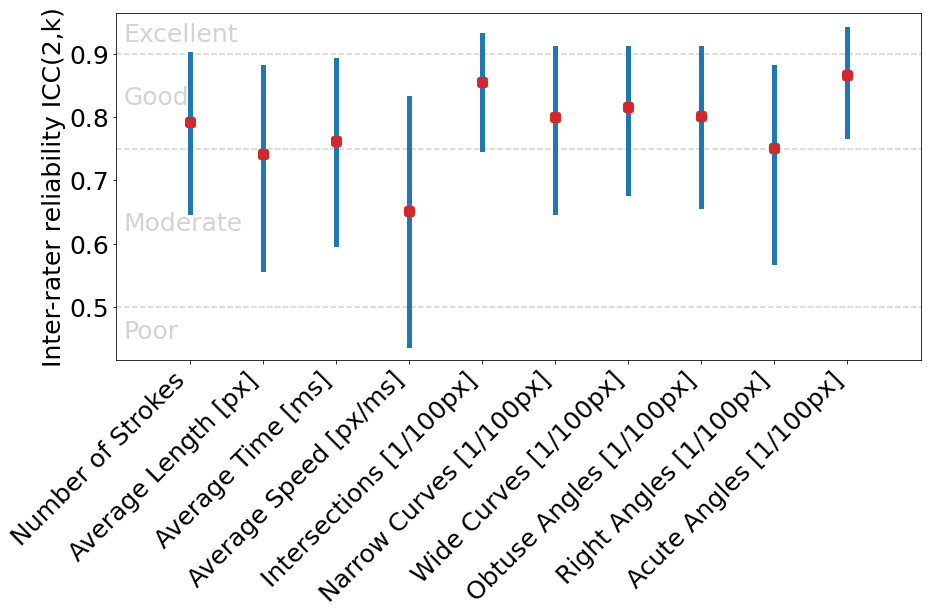

In [54]:
c = 'lightgrey'
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 25}

plt.rc('font', **font)
f = plt.figure() 
f.set_figwidth(13.5) 
f.set_figheight(9)

for y in [0.9,0.75,0.5]:
    plt.plot([-1,10],[y,y],c=c,ls='--')
    
plt.text(-0.9,0.92,'Excellent',c=c)
plt.text(-0.9,0.82,'Good',c=c)
plt.text(-0.9,0.62,'Moderate',c=c)
plt.text(-0.9,0.45,'Poor',c=c)

for ft in sketch_feature_names:
    ft_values = ICC2k_df.loc[ft]
    plt.scatter(ft,ft_values['ICC'],marker='s', c='tab:red' ,linewidth=5,zorder=200)
    plt.plot([ft,ft],[ft_values['CI95%'][0],ft_values['CI95%'][1]], c='tab:blue',linewidth=5)
    


plt.ylabel('Inter-rater reliability ICC(2,k)')
plt.xticks(rotation=45,ha='right')
plt.xlim((-1,10))
# plt.title('Inter-rater reliability for sketch features with')
plt.tight_layout()
plt.savefig('ICC.png')
plt.show()

## 3. Example of feature extraction
Display a specfic sketch and display information about it

In [46]:
#Create test dataset for shape primitives (square, triangle, circle)
test_data = []
shapes = []

#Create square
square = [[[100,650,650,100,100],[100,100,650,650,100],[0,1,2,3,4]]]
#Create triangle
triangle = [[[100,650,375,100],[100,100,650,100],[0,1,2,3]]]
#Create circle
circle_x = []
circle_y = []
circle_birth = []
r = 275
ctr = [375,375]
for i in range (360):
    angle = math.pi * i/180
    circle_x.append(r*np.cos(angle)+ctr[0])
    circle_y.append(r*np.sin(angle)+ctr[1])
    circle_birth.append(i)
shapes.append(square)
shapes.append(triangle)
shapes.append([[circle_x,circle_y,circle_birth]])

test_data.append(shapes)

/Users/sebastian/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:130: RuntimeWarning: invalid value encountered in double_scalars
  slope = r_num / ssxm
/Users/sebastian/opt/anaconda3/lib/python3.8/site-packages/scipy/stats/_stats_mstats_common.py:142: RuntimeWarning: divide by zero encountered in double_scalars
  sterrest = np.sqrt((1 - r**2) * ssym / ssxm / df)
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


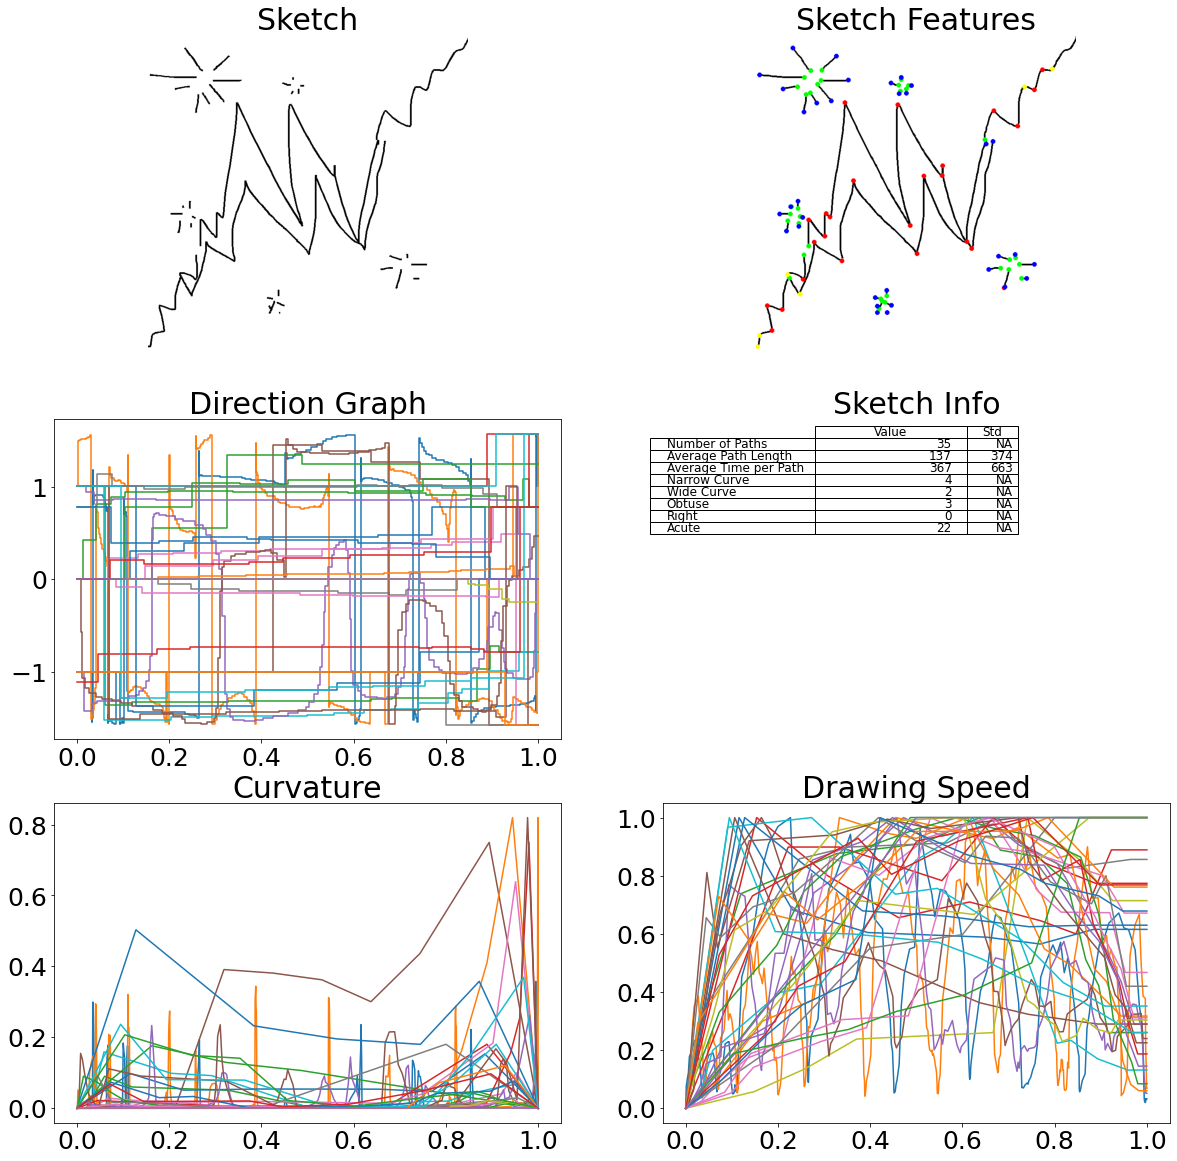

In [47]:
import scipy.stats as scipy
import sketchinfo

#Select sound and participant
sound_number =  '6'
participant_number = 5
dataset = sketch_data #Select which dataset to use: sketch_data for study data 
                      #test_data for test dataset with primitive shapes

#Get paths for specific sketch
sketch_paths = get_sketch_paths(participant=participant_number,sound=sound_number,sketch_data=dataset)

#Draw sketch data
sketch = draw_sketch(sketch_paths,(0,0,0),bg=(255,255,255),strength=4) #Call drawing function for specific sketch

#Get info for this sketch
number_of_paths, path_length, path_time, number_of_points = get_sketchinfo(sketch_paths)

#Get distances between points for this sketch and accumalted distances
distance_data, accl_dist_data = get_distances(sketch_paths)

#Get distances between points for this sketch and accumalted distances
time_data, accl_time_data = get_times(sketch_paths)

#Get direction graphs for this sketch
direction_data = direction_graph(sketch_paths,5)

#Get curvature
curvature_data = get_curvature(direction_data,accl_dist_data,2)

#Get speed data
speed_data = get_speed(distance_data,time_data,3)

#Get corners
ss = short_straw(sketch_paths)
all_corners = ss[0]
all_curves = ss[1]
feature_info = ss[2]
resampled_data = ss[3]

re_dst = get_distances(resampled_data)[0]

#Draw resampled version of sketch
resampled_sketch = draw_sketch(resampled_data,(0,0,0),bg=(255,255,255),strength=4)
draw = ImageDraw.Draw(resampled_sketch)

#Draw start/end point and corners  
for i,path in enumerate(all_corners):
    for index in path:
        x = resampled_data[i][0][index]
        y = resampled_data[i][1][index]        
        if index == path[-1]: #End point is blue
            colour = (0,0,255)
        elif index == path[0]:
            colour = (0,255,0) #Start point is green
        else:
            colour = (255,0,0) #Rest is red
        draw.ellipse((x-5,y-5,x+5,y+5),fill=colour) #Corner points are red

#Draw curve points
for i,path in enumerate(all_curves):
    for index in path:
        x = resampled_data[i][0][index]
        y = resampled_data[i][1][index] 
        draw.ellipse((x-5,y-5,x+5,y+5),fill=(255,255,0)) #Curve points are yellow

#Save image that includes shortstraw detection
resampled_sketch.save('shortstrawdetection','png')

#Great graphs and other display
fig, axes = plt.subplots(ncols=2, nrows=3, figsize=(20, 20))

#Give titles to axes
axes[0,0].set_title('Sketch')
axes[0,0].axis('off')
axes[0,1].set_title('Sketch Features')
axes[0,1].axis('off')
axes[1,0].set_title('Direction Graph')
axes[1,1].set_title('Sketch Info')
axes[1,1].axis('off')
axes[2,0].set_title('Curvature')
axes[2,1].set_title('Drawing Speed')

#original on the left
axes[0,0].imshow(sketch)
#resampled with feature analysis on the right
axes[0,1].imshow(resampled_sketch)

#table with info second row on the right
cell_text = [[number_of_paths,'NA'],
            [int(np.mean(path_length)),int(np.std(path_length))],
            [int(np.mean(path_time)),int(np.std(path_time))],
            [feature_info['narrow curve'],'NA'],
            [feature_info['wide curve'],'NA'],
            [feature_info['obtuse'],'NA'],
            [feature_info['right'],'NA'],
            [feature_info['acute'],'NA']]

columns=('Value','Std')
rows=('Number of Paths','Average Path Length','Average Time per Path','Narrow Curve','Wide Curve','Obtuse','Right','Acute')
info_table = axes[1,1].table(cellText=cell_text,
                      rowLabels=rows,
                      colLabels=columns,
                      loc='upper center', colWidths=(0.3,0.1,0.1))
info_table.auto_set_font_size(False)
info_table.set_fontsize(12)

#Draw graphs
for i in range(len(direction_data)):
    #Choose x-axis
    #x = accl_time_data[i] #absolute time
    x = [temp/accl_dist_data[i][-1] for temp in accl_dist_data[i]] #normalised distance
    #x = accl_dist_data[i] #absolute distance 
    
    #Direction Graph
    dir_y = direction_data[i]    
    #Plot data
    axes[1,0].step(x,dir_y) 
    
    #Curvature
    curve_y = [temp/(0.5*np.pi) for temp in curvature_data[i]] #normalise curvature data
    #Plot data
    axes[2,0].plot(x,curve_y)
    
    #Speed
    max_speed = max(speed_data[i])
    if(max_speed>0):
        speed_y = [temp/max(speed_data[i]) for temp in speed_data[i]] #normalise speed data
    else:
        speed_y = [0 for _ in speed_data[i]] #normalise speed data
    #Plot data
    axes[2,1].plot(x,speed_y)
    

#Show everything
plt.show()

In [48]:
#Show sketch with feature points
'''
Green = starting point
Blue = end point
Red = corner point
Yellow = curve point
'''


# resampled_sketch
def test_draw(paths,colour,bg,strength):
    sketch = Image.new('RGBA',(750,750),bg)
    draw = ImageDraw.Draw(sketch)
    #Draw each path as a continous 
    for j,path in enumerate(paths):
        points = len(path[0])
        for i in range(points):
            if i > 0:
                prev_x = path[0][i-1]
                prev_y = path[1][i-1]
                x = path[0][i]
                y = path[1][i]
                if type(colour) is tuple:
                    paint = colour
                else:
                    paint = colour[j][i]
                draw.line((prev_x,prev_y,x,y),fill=paint,width=strength)
    return sketch

example_sketches = [('Chaotic',3,6,''),('Chaotic',10,4,''),('Chaotic',13,10,''),('Chaotic',15,5,'B'),
                    ('Grains',4,1,'B'),('Grains',8,4,''),('Grains',11,6,'B'),('Grains',26,9,''),
                    ('Lines',1,2,''),('Lines',2,7,'B'),('Lines',22,9,''),('Lines',5,3,'B'),
                    ('Object',12,8,''),('Object',16,7,''),('Object',21,1,''),('Object',23,10,''),
                    ('Radiating',2,5,'B'),('Radiating',14,8,''),('Radiating',17,6,'B'),('Radiating',28,9,'')]

for file in example_sketches:
    if file[3] == 'B':
        i = 1
    else:
        i = 0
    pt = file[1]
    snd = str(file[2]) + file[3]
    
    sketch_paths = get_sketch_paths(participant=pt,sound=snd,sketch_data=dataset)
    sketch = test_draw(sketch_paths,colour=(0,0,0),bg=(255,255,255),strength=4)
    sketch_name = sound_index[file[2]-1] + ' (P' + str(file[1]) +')'
    draw = ImageDraw.Draw(sketch)
    font = ImageFont.truetype("ARIAL.TTF", 70)
    draw.text((10,670),sketch_name,font=font,fill=(0,0,0))
    
    filename = file[0] + '(pt' + str(file[1]) + 'snd' + str(file[2]) + file[3] + ').png'
    sketch.save(filename)

# V. Feature Correlation

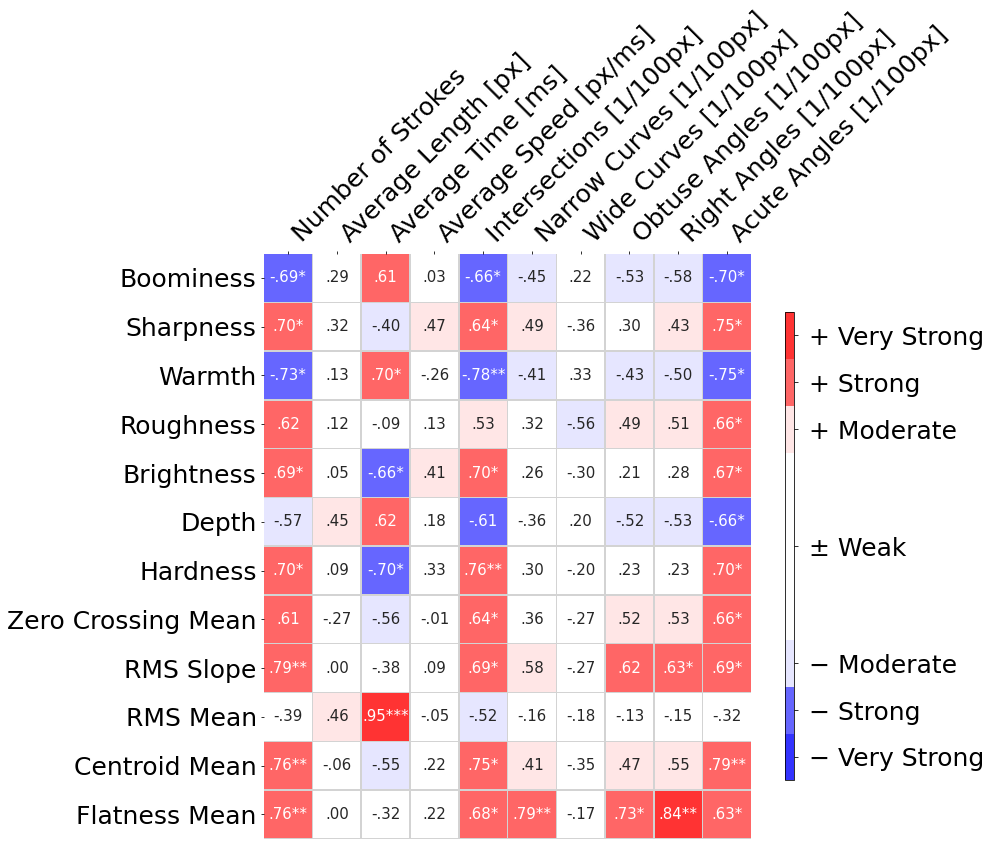

In [56]:
# This code is kind of messy because it originally had 3 graphs in mind

font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 15}

#Calculale Spearman Rank Correlation for #all sketches

#Array that holds reduced dataframes
dfs = [not3_ft_df,atleast3_for_3_df,aft_df]
dfs_labels = ["\n(Participants who never chose category 3: Objects/Scenes)",
              "\n(Participants who chose category 3: Objects/Scenes at least 3 times)",
             ""]    
    
#Subplots 
plt.rc('font', **font)
plt.rc('xtick',labelsize=25)
plt.rc('ytick',labelsize=25)
fig, axes = plt.subplots(ncols=1,nrows=1,figsize=(13.6,12))

for _ in range(1):
    df_index = 2
    df = dfs[df_index]
    #Spearman correlations
    rhos = np.zeros((audio_df.shape[1],(df.shape[1])))
    ps = np.zeros((audio_df.shape[1],(df.shape[1])))

    for i,audio_feature in enumerate(audio_df):
        a = audio_df[audio_feature]

        for j,sketch_feature in enumerate(df):

            b = df[sketch_feature]
            rho,p = stats.spearmanr(a,b)
            rhos[i][j] = rho
            ps[i][j] = p

    #Dataframe with p values
    cor_df = pd.DataFrame(data=ps,index=audio_feature_names,columns=sketch_feature_names).drop('Reverb')
    sdf = cor_df.style.applymap(color_negative_red)
    #Dataframe with rho values
    cor2_df = pd.DataFrame(data=rhos,index=audio_feature_names,columns=sketch_feature_names).drop('Reverb').round(2)

    #Annotation with * for significance levels
    cm_annot = []
    for i,row in enumerate(ps):
        annot_row = []
        for j,p in enumerate(row):
            rho = rhos[i,j]
            pre = '.'
            if rho < 0:
                pre = '-.'
            rho = int(abs(rho) * 100)
            rho_formatted = pre + "{:02d}".format(rho)
            if p<0.001:
                rho_formatted += '***'
            elif p<0.01:
                rho_formatted += '**'
            elif p<0.05:
                rho_formatted += '*'        
            annot_row.append(rho_formatted)
        cm_annot.append(annot_row)

    cm_annot_df = pd.DataFrame(data=cm_annot[:12])


    #Heatmap for correlation
    #Colours for sections:
    myColors = ((0.2,0.2,1.,1.),(0.4,0.4,1.,1.),(0.9,0.9,1.,1.),(1.,1.,1.,1.),(1.,1.,1.,1.),(1.,1.,1.,1.),(1.,1.,1.,1.),(1.,0.9,0.9,1.),(1.,0.4,0.4,1.),(1.,0.2,0.2,1.))
    cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

    hm = sns.heatmap(cor2_df, annot=cm_annot_df, vmin=-1,vmax=1, cmap=cmap, linewidths=.5, linecolor='lightgray',square=True, fmt='',ax=axes, cbar=False)
    ax = hm
    # Manually specify colorbar labelling after it's been generated
#     cb = ax.collections[0].colorbar
#     cb.solids.set_edgecolor("face")
#     cb.set_ticks([-0.9, -0.7, -0.5, 0.,0.5,0.7,0.9])
#     cb.set_ticklabels(['Negative very strong', 'Negative Strong', 'Negative Moderate','Weak','Positive Moderate','Positive Strong','Positive Very Strong'])
    ax.set_ylim(0, 12)
    ax.xaxis.tick_top()
    ax.set_xticklabels(sketch_feature_names,rotation=45,ha='left')
#     axes[df_index].set_title('Spearman rank correlation between sound and sketch features' + dfs_labels[df_index])
    # Only y-axis labels need their rotation set, x-axis labels already have a rotation of 0
_, labels = plt.yticks()

plt.setp(labels, rotation=0)
# plt.setp(_, rotation=45)
# plt.delaxes(axes[0])
# plt.delaxes(axes[1])
mappable = plt.cm.ScalarMappable(norm=None,cmap=cmap)
cb = fig.colorbar(mappable,orientation='vertical',ax=axes,shrink=0.8,anchor=(0.0,0.5),aspect=50)
cb.set_ticks([0.05, 0.15, 0.25, 0.5,0.75,0.85,0.95])
cb.set_ticklabels([' − Very Strong', ' − Strong', ' − Moderate',' ± Weak',' + Moderate',' + Strong',' + Very Strong'])
 
# axes[2].set_xticklabels(audio_feature_names[0:12],rotation=45,ha='right')
# axes[2].set_yticklabels(sketch_feature_names,rotation=45,ha='right')
plt.tight_layout()
plt.savefig('Spearman.png')
plt.show()